In [6]:
import sys
sys.path.append("../")
from database import models

In [ ]:
TM1_minus_20 = """
Probe 1: 0xf6b3
Probe 2: 0xf6d3
Probe 3: 0xf6db
""" #approx -18.3 for all so off by 1.7 degrees too warm

def convert_hex(hex:str):
    int_value = int(hex, 16)
    int_value >>= 3
    if int_value & 0x1000:
        int_value -= 0x2000
    return int_value * 0.0625

for probe_temp in TM1_minus_20.split("\n"):
    if probe_temp:
        probe, hex_temp = probe_temp.split(":")
        print(f"{probe.strip()} is {convert_hex(hex_temp.strip())} degrees C")
# see if TM2 is constant offset throughout then if so just do 2 deg offset

-18.3125
Probe 1 is -18.625 degrees C
Probe 2 is -18.375 degrees C
Probe 3 is -18.3125 degrees C


---------
Actual Temp: 10.1, Probe Temps: [11.75, 12.25, 12.1875]
Differences: [-1.6500000000000004, -2.1500000000000004, -2.0875000000000004]
---------
---------
Actual Temp: 5, Probe Temps: [6.6875, 7.1875, 7.1875]
Differences: [-1.6875, -2.1875, -2.1875]
---------
---------
Actual Temp: -0.1, Probe Temps: [1.5625, 2.0625, 2.0625]
Differences: [-1.6625, -2.1625, -2.1625]
---------
---------
Actual Temp: -5.1, Probe Temps: [-3.4375, -2.9375, -2.9375]
Differences: [-1.6624999999999996, -2.1624999999999996, -2.1624999999999996]
---------
---------
Actual Temp: -10.3, Probe Temps: [-8.5625, -8.0625, -8.125]
Differences: [-1.7375000000000007, -2.2375000000000007, -2.1750000000000007]
---------
---------
Actual Temp: -15, Probe Temps: [-13.3125, -12.8125, -12.8125]
Differences: [-1.6875, -2.1875, -2.1875]
---------
---------
Actual Temp: -19.8, Probe Temps: [-18.125, -17.625, -17.6875]
Differences: [-1.6750000000000007, -2.1750000000000007, -2.1125000000000007]
---------


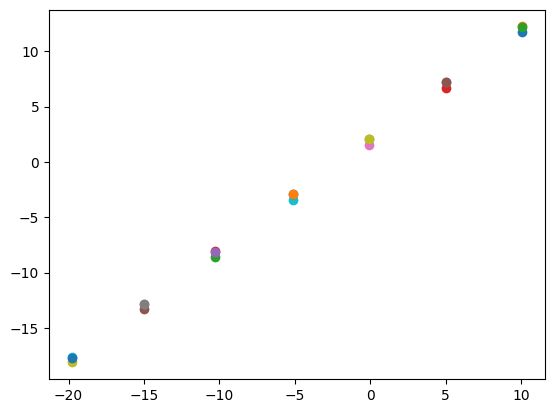

In [14]:
TM2_probe_calibration = {
    10.1: "Probe 1: 0x5e3, Probe 2: 0x623, Probe 3: 0x61b",
    5: "Probe 1: 0x35b, Probe 2: 0x39b, Probe 3: 0x39b",
    -0.1: "Probe 1: 0xcb, Probe 2: 0x10b, Probe 3: 0x10b",
    -5.1:"Probe 1: 0xfe4b, Probe 2: 0xfe8b, Probe 3: 0xfe8b",
    -10.3: "Probe 1: 0xfbbb, Probe 2: 0xfbfb, Probe 3: 0xfbf3",
    -15: "Probe 1: 0xf95b, Probe 2: 0xf99b, Probe 3: 0xf99b",
    -19.8: "Probe 1: 0xf6f3, Probe 2: 0xf733, Probe 3: 0xf72b"
}

import matplotlib.pyplot as plt
# print the actual temp and the probe temp
for actual_temp, raw_probe_temps in TM2_probe_calibration.items():
    probes = ["Probe 1", "Probe 2", "Probe 3"]
    probe_temps = [convert_hex(pt.split()[-1]) for pt in raw_probe_temps.split(', ')]
    differences = [actual_temp - pt for pt in probe_temps]

    for i, probe in enumerate(probes):
        plt.scatter(actual_temp, probe_temps[i], label=probe)

    
    print('---------')
    print(f"Actual Temp: {actual_temp}, Probe Temps: {probe_temps}")
    print(f"Differences: {[actual_temp - pt for pt in probe_temps]}")
    print('---------')


